In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

### Business and Data Understanding

As talk on Airbnb kaggle data website, the following Airbnb activity is included in this Boston dataset: 
* Calendar, including listing id and the price and availability for that day
* Listings, including full descriptions and average review score 
* Reviews, including unique id for each reviewer and detailed comments 


Let us take a look on these three csv files.

#### Calendar

In [2]:
cdf = pd.read_csv('./boston-airbnb/calendar.csv')
cdf.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


It shows that the hosts are not avaible everyday and price may be changed at the busiest seasons. 

* What is the most expensive season in Boston? 
* Which hosts are the most favorite？

#### Listings

In [3]:
ldf = pd.read_csv('./boston-airbnb/listings.csv')
ldf.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


Summary information on listing in Boston.It contains location, host information, cleaning and guest fees, amenities and so on.
We may find some import factors on price.

* What are the top factors strong relation to price?
* How to predict price？


#### Reviews

In [4]:
rdf = pd.read_csv('./boston-airbnb/reviews.csv')
rdf.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


We can find many interesting opinions,sush as 

* What are the most attractive facilities? It is big bed, large room or location?
* What will lead to bad impression？

### Data preparing

#### Clean Calendar

In [5]:
def clean_calendar(df):
    # Filter unavailable data.
    df = df[df['available'] == 't'].copy()
    
    # Remove "$," in price and convert to float
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].astype(float)
    
    # Set year/month
    df['year'] = df['date'].str[0:4]
    df['month'] = df['date'].str[5:7]
    
    return df
    

In [6]:
# clean data
cdf_clean = clean_calendar(cdf)

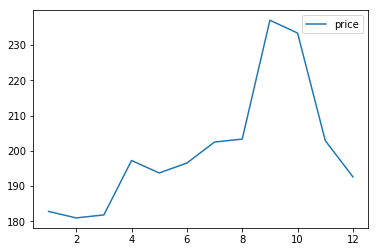

In [7]:
# get average price every month and plot
cdf_avg = cdf_clean.groupby(['month'], as_index=False)['price'].mean()

cdf_avg.index = cdf_avg.index+1
cdf_avg.plot()

* So we can see the most expensive season is from August to November，especial September and October. 
* You can get a lowest price if you go to Boston at February.

In [37]:
# The most expensive listing_id
cdf_clean.loc[cdf_clean['price'].idxmax()]

listing_id        447826
date          2016-10-26
available              t
price               7163
year                2016
month                 10
Name: 110179, dtype: object

* The most expensive listing_id is 447826.Go to Boston and experience one night.

In [49]:
ldf[ldf.id==447826][['id','listing_url','scrape_id','host_url','name',
                     'bedrooms','accommodates','bathrooms','amenities']].T

,301
id,447826
listing_url,https://www.airbnb.com/rooms/447826
scrape_id,20160906204935
host_url,https://www.airbnb.com/users/show/2053557
name,"Sweet Little House in JP, Boston"
bedrooms,1
accommodates,2
bathrooms,1
amenities,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


![Sweet Little House in JP, Boston](./boston-airbnb/447826.png)

#### Clean Listings

In [8]:
def trans_amenities(df):
    # amenities is json object,can't trans as normal dummy variable
    df['amenities'] = df['amenities'].map(lambda amns: "|".join(
        [amn.replace("}", "").replace("{", "").replace('"', "") for amn in amns.split(",")]))


    amenities = np.unique(np.concatenate(df['amenities'].map(lambda amns: amns.split("|"))))[1:]
    amenity_arr = np.array([df['amenities'].map(lambda amns: amn in amns) for amn in amenities])
    return pd.DataFrame(data=amenity_arr.T, columns=amenities)
    

def create_dummy_df(df):
    # get string columns
    cat_cols = df.select_dtypes(include=['object']).columns
    # set dummy columns
    for col in  cat_cols:
        try:
            # json object
            if col == 'amenities':
                df = pd.concat([df.drop(col, axis=1),trans_amenities(df)])
            # boolean str(f/t)
            elif col in ['host_is_superhost', 'host_identity_verified', 
                            'host_has_profile_pic','is_location_exact', 
                            'requires_license', 'instant_bookable',
                            'require_guest_profile_picture','require_guest_phone_verification']:
                df[col] = df[col].map(lambda s: 0 if s == "f" else 1)
            # category
            else:
                # for each cat add dummy var, drop original column
                df = pd.concat([df.drop(col, axis=1), 
                            pd.get_dummies(df[col], prefix=col, prefix_sep='_', 
                                           drop_first=True, dummy_na=False)], axis=1)
        except:
            continue
    return df

def clean_listings(df):   
    # Drop the rows with missing price
    df = df.dropna(subset=['price'], axis=0)
    
    # Drop the nan columns
    df = df.dropna(how='all', axis=1)

    # Remove "$," in price and convert to float
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].astype(float)
    
    #Dummy categorical variables
    df = create_dummy_df(df)

    # Median function
    fill_mean = lambda col: col.fillna(col.median())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)
    
    return df
    

In [9]:
# Only use quant/cate variables and drop any rows with missing values
num_vars = ldf[['price','host_listings_count', 'host_total_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds', 'guests_included', 'number_of_reviews',
                     'review_scores_rating','amenities','host_is_superhost', 'host_identity_verified',
                     'host_has_profile_pic','is_location_exact', 'requires_license', 'instant_bookable',
                     'require_guest_profile_picture', 'require_guest_phone_verification',
                     'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']]

ldf_clean = clean_listings(num_vars)

Let us calculate the mean/std of 'Price'.

* Assuming that prices obey normal distribution
* The price should be between mean-2*std~mean+2*std

In [10]:
ldf_clean['price'].describe()

count    7170.000000
mean      161.962901
std       105.558926
min        10.000000
25%       150.000000
50%       150.000000
75%       150.000000
max      4000.000000
Name: price, dtype: float64

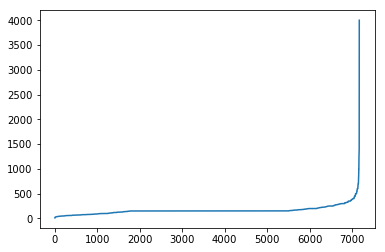

In [11]:
# plot price
ldf_clean['price'].sort_values().reset_index(drop=True).plot()

In [12]:
# fitler price
threshold = 500 
ldf_clean = ldf_clean[ldf_clean.price<=threshold]

#### Clean Reviews

Review the reviews.csv file,you will find there are different languages.We just need to keep the english comment.<br>
We need a lib 'langdetect'.

```
pip install langdetect
```

In [13]:
rdf.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [14]:
def detect_safe(c):
    try:
        return detect(c) == 'en'
    except:
        pass
    return False

def clean_reviews(df):
    # check comments language
    df['is_en'] = df['comments'].apply(lambda c:detect_safe(c))
    return df[df.is_en]

In [15]:
rdf_clean = clean_reviews(rdf)

In [16]:
rdf_clean.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,is_en
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,True
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,True
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,True
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,True
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,True


### Modeling and  evaluation

Let's try to predict the price based on the columns in the listing we selected.

In [26]:
#Split into explanatory and response variables
X = ldf_clean.drop(['price'], axis=1)
y = ldf_clean['price']

#Split into train and test
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=RAND_STATE) 

# train a RandomForest model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)
forest.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = forest.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.6256165829115665 on 2132 values.'

* What are the top factors strong relation to price?

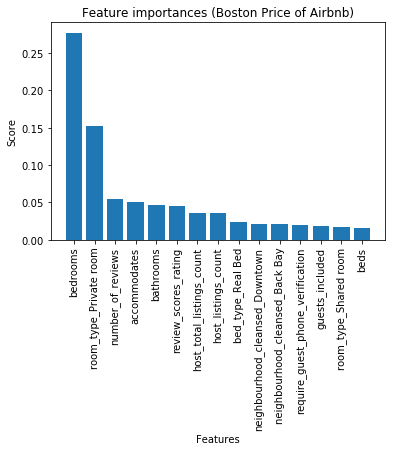

In [29]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.bar(y_pos, scores, align='center')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Boston Price of Airbnb)')

Top 6 factors strong relation to price:
* bedrooms
* room type : Private room
* number of reviews
* accommodates
* bathrooms
* review scores rating

### Deployment

Mostly,the model will be deplyed on product environment based on a RPC server or http server.<br>
You can deploy the model with Tornado(python web framework).